# Grid Search

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import pandas as pd
# Own library
import test3
# Needed to clean memory
import gc

# To modify scipts remotly
%load_ext autoreload
%autoreload 2

In [2]:
np.random.seed(94)
tf.random.set_seed(94)
(_, _), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_test = x_test / 255.0
x_test, y_test = tf.constant(x_test), tf.constant(y_test)

In [3]:
n_example = 4
x_test = x_test[:n_example]
y_test = tf.squeeze(tf.one_hot(y_test[:n_example], 10))

In [4]:
path = 'data/model_cifar.h5'
model = tf.keras.models.load_model(path)

In [5]:
# Considering a tensor as one single example of high dim
_, p = 1, np.prod(x_test.shape[1:])

In [6]:
# Parameter space
list_eta = [25/255]
list_epsilon = np.array(range(0, 9)) * 1/255 * 1000
list_n_steps = [50]
list_losses = [tf.keras.losses.CategoricalCrossentropy()]
list_methods = [test3.pgd_infinity]

# Generate parameters grid
iter_parameters_grid = itertools.product(list_methods, list_eta, list_epsilon, list_n_steps, list_losses)


# Names of methods
list_method_names = ['pgd_infinity', 'pgd_l2']

In [7]:
# Compute different attack sets
nested_tensor_exemples = []

for method in list_method_names:
    if method == 'pgd_l2':
        list_epsilon *= np.sqrt(p)
        list_methods = [test3.pgd_l2]
        iter_parameters_grid = itertools.product(list_methods, list_eta, list_epsilon, list_n_steps, list_losses)
    
    
    tensor_exemples = []
    
    for method, eta, eps, n_steps, loss in iter_parameters_grid:

        if eps == 0:
            tensor_exemples.append(x_test)
            continue

        if eta > eps:
            # Does not make sense to test this parameters config
            nested_accuracies.append([np.nan, np.nan])
            continue



        x_adv = method(x_test, y_test, model, loss_fn=loss, eta=eta, eps=eps, n_steps=n_steps)
        # Re-scaling image (they are normalized)
        x_adv = tf.clip_by_value(x_adv, 0, 1)
        # Clear memory
        gc.collect()
        tf.keras.backend.clear_session()

        tensor_exemples.append(x_adv)
        del x_adv
        
    nested_tensor_exemples.append(tensor_exemples)


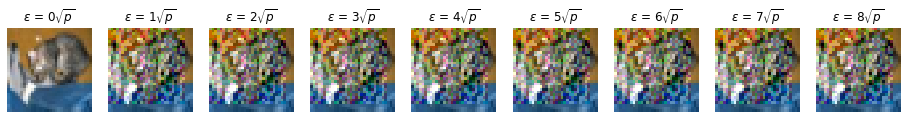

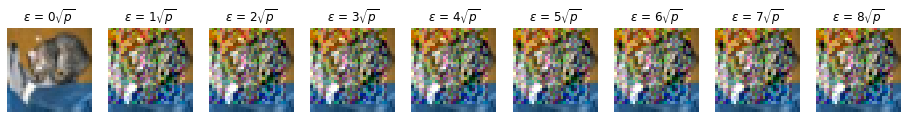

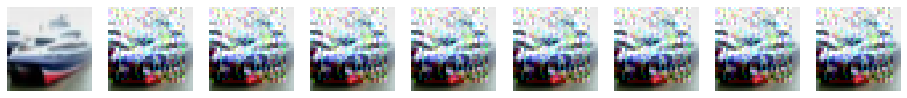

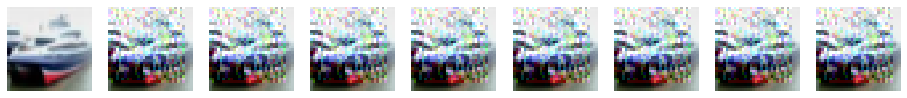

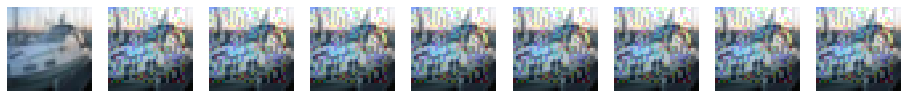

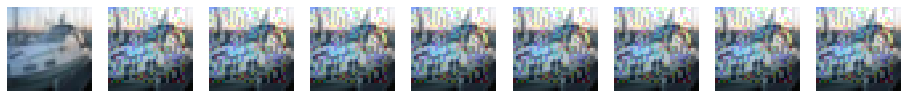

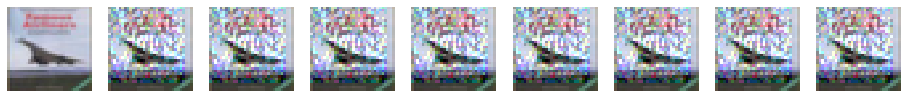

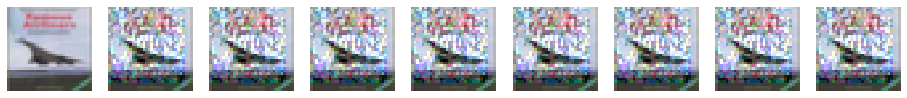

In [8]:
for j in range(n_example):
    for tensor_exemples in nested_tensor_exemples:
        plt.figure(figsize=(16, 8))
        for i in range(0, len(tensor_exemples)):
            plt.subplot(n_example, len(tensor_exemples), i + 1)
            plt.imshow(tensor_exemples[i][j], cmap="gray")
        #     plt.text(0, 2, s=,
        #               bbox=dict(facecolor='blue', alpha=0.9),
        #               color="white")
            if j == 0:
            
                plt.title(f"$\epsilon$ = {i}$\sqrt{{p}}$")


        #   prediction = model.predict(np.expand_dims(x[i], 0))
        #   prediction = np.argmax(prediction)

        #   color = "green" if prediction == y[i] else "red"

        #   plt.text(0, 26, s=f"y_pred={class_to_name[prediction]}",
        #           bbox=dict(facecolor=color, alpha=0.9),
        #           color="white")

            plt.axis("off")
        plt.show()

In [9]:
index = pd.MultiIndex.from_product([list_method_names, list_eta, list_epsilon],
                                   names=['method', 'tau', 'epsilon'])

In [10]:
# Graphs when step size is big
index = pd.MultiIndex.from_product([list_method_names, list_eta, list_epsilon,
                                    list_n_steps, [loss.name for loss in list_losses]],
                                   names=['method', 'eta', 'epsilon', 'n_steps', 'loss_name'])

df_results = pd.DataFrame(data=nested_accuracies,
                          columns=['loss', 'accuracy'],
                          index=index)

NameError: name 'nested_accuracies' is not defined

In [ ]:
path = './data/df_results.pickle'
import pickle
with open(path, 'wb') as f:
    pickle.dump(df_results, f)